## 89% ACC

Accuracy no teste: 0.8993
Accuracy no treino: 0.9453
Diferença (treino - teste): 0.0460
Não aparenta haver overfitting


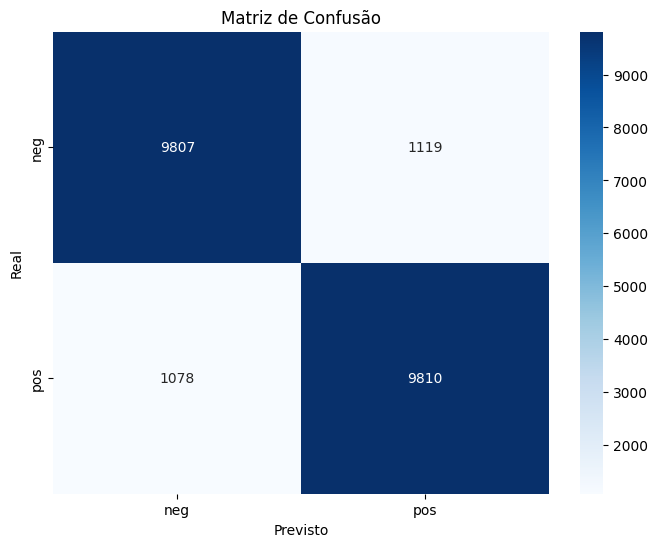

In [5]:
# Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import string
import contractions
import re
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Carregar dados
train_df = pd.read_csv('imdb_reviews_train.csv')
test_df = pd.read_csv('imdb_reviews_test.csv')

# Remover duplicados
train_df = train_df.drop_duplicates(subset=['text', 'label']).reset_index(drop=True)
test_df = test_df.drop_duplicates(subset=['text', 'label']).reset_index(drop=True)

# Padrões de substituição
replace_no_space = re.compile("[.;:!\'?,\"()\[\]]")
replace_with_space = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

lemmatizer = WordNetLemmatizer() # Fora da funçao para melhorar desempenho

# Definir função de processamento
def process_text(text):
    # Lowercase e aplicar substituições com regex
    text = contractions.fix(text)
    text = text.lower()
    text = replace_no_space.sub("", text)
    text = replace_with_space.sub(" ", text)
    # Tokenizar e aplicar lemmatization
    tokens = word_tokenize(text)  
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Juntar tokens processados
    return ' '.join(tokens)

# Aplicar processamento
train_df['processed_text'] = train_df['text'].apply(process_text)
test_df['processed_text'] = test_df['text'].apply(process_text)

# Vetorização TF-IDF
vetorizador = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,3),
    min_df=5,
    sublinear_tf=True,
    stop_words=['in', 'of', 'at', 'a', 'the', 'and', 'or', 'to', 'be', 'is', 'are', 'was', 'were'])
X_treino = vetorizador.fit_transform(train_df['processed_text'])
X_teste = vetorizador.transform(test_df['processed_text'])

# Codificação de labels
codificador = LabelEncoder()
y_treino = codificador.fit_transform(train_df['label'])
y_teste = codificador.transform(test_df['label'])

# Criar e treinar modelo
modelo = LogisticRegression(
    C=2.0, # Melhor configuração com os testes realizados, um C mais alto leva a overfitting              
    max_iter=1000,
    random_state=42
)
modelo.fit(X_treino, y_treino)

# Fazer previsões
previsoes = modelo.predict(X_teste)

# Calcular accuracy
acc = accuracy_score(y_teste, previsoes)

# Avaliar no conjunto de treino
previsoes_treino = modelo.predict(X_treino)
acc_treino = accuracy_score(y_treino, previsoes_treino)

# Comparar accuracies
print(f"Accuracy no teste: {acc:.4f}")
print(f"Accuracy no treino: {acc_treino:.4f}")
print(f"Diferença (treino - teste): {acc_treino - acc:.4f}")

# Verificar se há indício de overfitting
if acc_treino - acc > 0.05:
    print("Possível overfitting")
else:
    print('Não aparenta haver overfitting')

# Criar matriz de confusão
matriz = confusion_matrix(y_teste, previsoes)
plt.figure(figsize=(8, 6))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
            xticklabels=codificador.classes_,
            yticklabels=codificador.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [6]:
# Análise dos erros que o modelo classificou mal

pd.set_option('display.max_colwidth', None)  # Mostra o texto completo

# Índices dos falsos positivos e negativos
falsos_positivos_idx = np.where((previsoes == 1) & (y_teste == 0))[0]
falsos_negativos_idx = np.where((previsoes == 0) & (y_teste == 1))[0]

# Selecionar exemplos com ambas as colunas
falsos_positivos_exemplos = test_df.iloc[falsos_positivos_idx[:20]][['text', 'processed_text', 'label']]
falsos_negativos_exemplos = test_df.iloc[falsos_negativos_idx[:20]][['text', 'processed_text', 'label']]

print("Falsos Positivos:")
print(falsos_positivos_exemplos)

print("\nFalsos Negativos:")
print(falsos_negativos_exemplos)

Falsos Positivos:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## 90% Acc

In [7]:
# Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import contractions
import string
import re
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Carregar dados
train_df = pd.read_csv('imdb_reviews_train.csv')
test_df = pd.read_csv('imdb_reviews_test.csv')

# Padrões de substituição limpeza
replace_no_space = re.compile("[.;:!\'?,\"()\[\]]")
replace_with_space = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
replace_numbers = re.compile(r'\d+')  # Substituir números

# Inicializar lemmatizer fora da função (melhoria de desempenho)
lemmatizer = WordNetLemmatizer()

#Função para converter tags POS do NLTK para formato WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a' # adjetivo
    elif treebank_tag.startswith('V'):
        return 'v' # verbo
    elif treebank_tag.startswith('N'):
        return 'n' # substantivo
    elif treebank_tag.startswith('R'):
        return 'r' # advérbio
    else:
        return 'n' # substantivo por padrão

# Definir função de processamento - pequenos ajustes
def process_text(text):
    # Tratar valores nulos/não-string
    if not isinstance(text, str):
        return ""
    # Lowercase e aplicar substituições com regex
    text = contractions.fix(text)
    text = text.lower()
    text = replace_no_space.sub("", text)
    text = replace_with_space.sub(" ", text)
    text = replace_numbers.sub(" NUM ", text)  # Substituir números por token genérico
    # Tokenizar e aplicar lemmatization
    tokens = word_tokenize(text)
    # Aplicar POS tagging
    tagged_tokens = pos_tag(tokens)
    # Lemmatização
    tokens = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag))
          for word, tag in tagged_tokens]
    # Juntar tokens processados
    return ' '.join(tokens)

# Aplicar processamento
train_df['processed_text'] = train_df['text'].apply(process_text)
test_df['processed_text'] = test_df['text'].apply(process_text)

# Lista de stopwords
custom_stop_words = ['in', 'of', 'at', 'a', 'the', 'and', 'or', 'to', 'be', 'is', 'are', 'was', 'were']

# Vetorização TF-IDF - ajustes suaves
vetorizador = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,3),
    min_df=3,            # Ligeiramente reduzido para capturar termos menos frequentes
    sublinear_tf=True,   # Melhor escala logarítmica para termos frequentes
    stop_words=custom_stop_words
)
X_treino = vetorizador.fit_transform(train_df['processed_text'])
X_teste = vetorizador.transform(test_df['processed_text'])

# Codificação de labels
codificador = LabelEncoder()
y_treino = codificador.fit_transform(train_df['label'])
y_teste = codificador.transform(test_df['label'])

# Criar e treinar modelo
modelo = LogisticRegression(
    C=3.0,               # Aumentado para reduzir regularização
    max_iter=1000,
    random_state=42
)
modelo.fit(X_treino, y_treino)

# Fazer previsões
previsoes = modelo.predict(X_teste)

# Calcular accuracy
acc = accuracy_score(y_teste, previsoes)

# Avaliar no conjunto de treinamento
previsoes_treino = modelo.predict(X_treino)
acc_treino = accuracy_score(y_treino, previsoes_treino)

# Comparar accuracies
print(f"Accuracy no teste: {acc:.4f}")
print(f"Accuracy no treino: {acc_treino:.4f}")
print(f"Diferença (treino - teste): {acc_treino - acc:.4f}")

# Verificar se há indício de overfitting
if acc_treino - acc > 0.05:
    print("Possível overfitting")
else:
    print('Não aparenta haver overfitting')

# Criar matriz de confusão
matriz = confusion_matrix(y_teste, previsoes)
plt.figure(figsize=(8, 6))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
            xticklabels=codificador.classes_,
            yticklabels=codificador.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


Accuracy no teste: 0.9001
Accuracy no treino: 0.9489
Diferença (treino - teste): 0.0488
Não aparenta haver overfitting


## Teste de melhor extração de features

In [8]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import contractions
import re
from gensim.models import Word2Vec, FastText
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Carregar dados
train_df = pd.read_csv('imdb_reviews_train.csv')
test_df = pd.read_csv('imdb_reviews_test.csv')

# Padrões de substituição
replace_no_space = re.compile("[.;:!\'?,\"()\[\]]")
replace_with_space = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

# Inicializar lemmatizer
lemmatizer = WordNetLemmatizer()

# Função de processamento com lemmatização
def process_text(text):
    text = contractions.fix(text)
    text = text.lower()
    text = replace_no_space.sub("", text)
    text = replace_with_space.sub(" ", text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Aplicar processamento
train_df['processed_text'] = train_df['text'].apply(process_text)
test_df['processed_text'] = test_df['text'].apply(process_text)

# Codificação de labels
codificador = LabelEncoder()
y_treino = codificador.fit_transform(train_df['label'])
y_teste = codificador.transform(test_df['label'])

# TF-IDF 
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,3),
    min_df=5,
    sublinear_tf=True,
    stop_words=['in', 'of', 'at', 'a', 'the', 'and', 'or', 'to', 'be', 'is', 'are', 'was', 'were']
)
X_treino_tfidf = tfidf.fit_transform(train_df['processed_text'])
X_teste_tfidf = tfidf.transform(test_df['processed_text'])

# BoW 
bow = CountVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    min_df=5,
    stop_words=['in', 'of', 'at', 'a', 'the', 'and', 'or', 'to', 'be', 'is', 'are', 'was', 'were']
)
X_treino_bow = bow.fit_transform(train_df['processed_text'])
X_teste_bow = bow.transform(test_df['processed_text'])

# Word2Vec
sentences_w2v = [text.split() for text in train_df['processed_text']]
w2v_model = Word2Vec(sentences_w2v, vector_size=100, window=5, min_count=5, workers=4)

def get_w2v_features(texts, model, size):
    features = []
    for text in texts:
        words = text.split()
        vecs = [model.wv[word] for word in words if word in model.wv]
        features.append(np.mean(vecs, axis=0) if vecs else np.zeros(size))
    return np.array(features)

X_treino_w2v = get_w2v_features(train_df['processed_text'], w2v_model, 100)
X_teste_w2v = get_w2v_features(test_df['processed_text'], w2v_model, 100)

# FastText
sentences_ft = [text.split() for text in train_df['processed_text']]
ft_model = FastText(
    sentences_ft,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    min_n=3,
    max_n=6
)

def get_ft_features(texts, model, size):
    features = []
    for text in texts:
        words = text.split()
        vecs = [model.wv[word] for word in words]
        features.append(np.mean(vecs, axis=0) if vecs else np.zeros(size))
    return np.array(features)

X_treino_ft = get_ft_features(train_df['processed_text'], ft_model, 100)
X_teste_ft = get_ft_features(test_df['processed_text'], ft_model, 100)

# Avaliação 
def avaliar(X_tr, X_te, y_tr, y_te, nome):
    modelo = LogisticRegression(C=2.0, max_iter=1000, random_state=42, solver='saga')
    modelo.fit(X_tr, y_tr)
    acc_tr = accuracy_score(y_tr, modelo.predict(X_tr))
    acc_te = accuracy_score(y_te, modelo.predict(X_te))
    return {
        'Método': nome,
        'Accuracy Teste': acc_te,
        'Accuracy Treino': acc_tr,
        'Diferença': acc_tr - acc_te
    }

resultados = [
    avaliar(X_treino_tfidf, X_teste_tfidf, y_treino, y_teste, 'TF-IDF'),
    avaliar(X_treino_bow, X_teste_bow, y_treino, y_teste, 'BoW'),
    avaliar(X_treino_w2v, X_teste_w2v, y_treino, y_teste, 'Word2Vec'),
    avaliar(X_treino_ft, X_teste_ft, y_treino, y_teste, 'FastText')
]

df_resultados = pd.DataFrame(resultados)
print("\nComparação Final:")
print(df_resultados.sort_values('Accuracy Teste', ascending=False))

# Gráfico Comparativo
plt.figure(figsize=(12,6))
df_resultados.set_index('Método')[['Accuracy Treino', 'Accuracy Teste']].plot(kind='bar')
plt.title('Desempenho dos Métodos de Feature Engineering')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Avaliação
def avaliar(X_tr, X_te, y_tr, y_te, nome):
    modelo = LogisticRegression(C=2.0, max_iter=1000, random_state=42, solver='saga')
    modelo.fit(X_tr, y_tr)
    acc_tr = accuracy_score(y_tr, modelo.predict(X_tr))
    acc_te = accuracy_score(y_te, modelo.predict(X_te))
    return {
        'Método': nome,
        'Accuracy Teste': acc_te,
        'Accuracy Treino': acc_tr,
        'Diferença': acc_tr - acc_te
    }

resultados = [
    avaliar(X_treino_tfidf, X_teste_tfidf, y_treino, y_teste, 'TF-IDF'),
    avaliar(X_treino_bow, X_teste_bow, y_treino, y_teste, 'BoW'),
    avaliar(X_treino_w2v, X_teste_w2v, y_treino, y_teste, 'Word2Vec'),
    avaliar(X_treino_ft, X_teste_ft, y_treino, y_teste, 'FastText')
]

df_resultados = pd.DataFrame(resultados)
print("\nComparação Final:")
print(df_resultados.sort_values('Accuracy Teste', ascending=False))


c:\Users\Bruno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Comparação Final:
     Método  Accuracy Teste  Accuracy Treino  Diferença
0    TF-IDF        0.898618         0.948377   0.049759
1       BoW        0.872750         0.998253   0.125504
2  Word2Vec        0.812557         0.815298   0.002742
3  FastText        0.790780         0.793693   0.002913


<Figure size 1200x600 with 0 Axes>

c:\Users\Bruno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Comparação Final:
     Método  Accuracy Teste  Accuracy Treino  Diferença
0    TF-IDF        0.898618         0.948377   0.049759
1       BoW        0.872750         0.998253   0.125504
2  Word2Vec        0.812557         0.815298   0.002742
3  FastText        0.790780         0.793693   0.002913


## Teste dos melhores modelos

In [9]:
# Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import contractions
import string
import re
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Carregar dados
train_df = pd.read_csv('imdb_reviews_train.csv')
test_df = pd.read_csv('imdb_reviews_test.csv')

# Padrões de substituição
replace_no_space = re.compile("[.;:!\'?,\"()\[\]]")
replace_with_space = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

lemmatizer = WordNetLemmatizer() # Fora da funçao para melhorar desempenho

# Definir função de processamento
def process_text(text):
    # Lowercase e aplicar substituições com regex
    text = contractions.fix(text)
    text = text.lower()
    text = replace_no_space.sub("", text)
    text = replace_with_space.sub(" ", text)
    # Tokenizar e aplicar lemmatization
    tokens = word_tokenize(text)  
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Juntar tokens processados
    return ' '.join(tokens)

# Aplicar processamento
train_df['processed_text'] = train_df['text'].apply(process_text)
test_df['processed_text'] = test_df['text'].apply(process_text)

# Vetorização TF-IDF
vetorizador = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,3),
    min_df=5,
    sublinear_tf=True,
    stop_words=['in', 'of', 'at', 'a', 'the', 'and', 'or', 'to', 'be', 'is', 'are', 'was', 'were'])
X_treino = vetorizador.fit_transform(train_df['processed_text'])
X_teste = vetorizador.transform(test_df['processed_text'])

# Codificação de labels
codificador = LabelEncoder()
y_treino = codificador.fit_transform(train_df['label'])
y_teste = codificador.transform(test_df['label'])

# Modelos

# Rede Neural (MLPClassifier)
modelo_nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
modelo_nn.fit(X_treino, y_treino)

# SVM
modelo_svm = SVC(kernel='linear', C=1.0, random_state=42)
modelo_svm.fit(X_treino, y_treino)

# Naive Bayes Multinomial
modelo_nb = MultinomialNB()
modelo_nb.fit(X_treino, y_treino)

# LR
modelo_lr = LogisticRegression(C=2.0, max_iter=1000, random_state=42, solver='saga')
modelo_lr.fit(X_treino, y_treino)

#Função para avaliar overfitting 
def avaliar_overfitting(modelo, X_treino, y_treino, X_teste, y_teste):
    previsoes_treino = modelo.predict(X_treino)
    acc_treino = accuracy_score(y_treino, previsoes_treino)
    previsoes_teste = modelo.predict(X_teste)
    acc_teste = accuracy_score(y_teste, previsoes_teste)
    return {
        'Modelo': modelo.__class__.__name__,
        'Accuracy Treino': acc_treino,
        'Accuracy Teste': acc_teste,
        'Diferença': acc_treino - acc_teste
    }

# Avaliar todos os modelos
resultados = [
    avaliar_overfitting(modelo_nn, X_treino, y_treino, X_teste, y_teste),
    avaliar_overfitting(modelo_svm, X_treino, y_treino, X_teste, y_teste),
    avaliar_overfitting(modelo_nb, X_treino, y_treino, X_teste, y_teste),
    avaliar_overfitting(modelo_lr, X_treino, y_treino, X_teste, y_teste)
]

# Exibir resultados em tabela
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

#  Visualização 
plt.figure(figsize=(10,6))
df_resultados.set_index('Modelo')[['Accuracy Treino', 'Accuracy Teste']].plot(kind='bar')
plt.title('Comparação de Overfitting entre Modelos')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()

# Matriz de confusão para o melhor modelo 
# Escolher o modelo com maior acurácia de teste
melhor_idx = df_resultados['Accuracy Teste'].idxmax()
melhor_modelo_nome = df_resultados.loc[melhor_idx, 'Modelo']
if melhor_modelo_nome == 'MLPClassifier':
    melhor_modelo = modelo_nn
elif melhor_modelo_nome == 'SVC':
    melhor_modelo = modelo_svm
elif melhor_modelo_nome == 'LogisticRegression':
    melhor_modelo = modelo_lr
else:
    melhor_modelo = modelo_nb

previsoes = melhor_modelo.predict(X_teste)
matriz = confusion_matrix(y_teste, previsoes)
plt.figure(figsize=(8, 6))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
            xticklabels=codificador.classes_,
            yticklabels=codificador.classes_)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão ({melhor_modelo_nome})')
plt.show()

               Modelo  Accuracy Treino  Accuracy Teste  Diferença
0       MLPClassifier         0.999954        0.863975   0.135979
1                 SVC         0.956744        0.893026   0.063718
2       MultinomialNB         0.892985        0.873113   0.019872
3  LogisticRegression         0.948377        0.898618   0.049759


<Figure size 1000x600 with 0 Axes>